# 1 - Bucketing

## First we will import libraries and define the folder_path and signal_names

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
# Define the directory containing CSV files
folder_path = r"D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase_Bad_Clustered"
signal_names = [
    "Stand 1 Predicted Run Force",
    "Stand 1 Gap Stick Offset",
    "Tension Reel Calculated Tension",
    "Tension To Gap 2 In Limit",
    "Stand 1-2 Total Tension Feedback",
    "Ramp Greater Than Thread",
    "Stand 3 - Operator Side Force",
    "Flatness Control - Bending In Limit",
    "Stand 1 Run Gap Setpoint",
    "Stand 1 Gap Bite Offset",
    "S1 Operating Bending Trim",
    "Stand 2-3 Tension Reference",
    "Neet Oil Concentration",
    "Morgoil DriveTop Bearing Outflow Temp Stand1",
    "Stand 4 Top Current Feedback",
    "Morgoil DriveTop Bearing Outflow Temp Stand3",
    "Stand 3 Run Gap Setpoint",
    "Stand 2 Total Bending Feedback",
    "Stand 2 Gap Bite Offset",
    "Morgoil OperBottom Bearing Outflow Temp Stand3",
    "Stand 4 Thread Gap Setpoint",
    "X4 Gauge Deviation",
    "Stand 4 DS Total Bending Feedback",
    "Laser 0 Data Valid",
    "Stand 4 - Operator Side Force",
    "Stand 2 Gap Eccentricity Trim",
    "Stand 4 Gap Operator Offset",
    "Stand 3 Total Bending Feedback",
    "Strip In Stand 3",
    "Morgoil OperTop Bearing Outflow Temp Stand1",
    "Strip In Stand 1",
    "X1 Gauge Deviation",
    "Stand 3 Drive Speed Feedback",
    "Stand 2 Gap Thread Offset",
    "Stand 2 Drive Speed Feedback",
    "Stand 1-3 Solution System Pressure",
    "Stand 2 Top Current Feedback",
    "Stand 1-3 Solution Temperature",
    "AGC GE Feedforward Hardness Number",
    "Stand 1 Total Bending Feedback",
    "X0 Gauge Deviation",
    "Stand 3 Bottom Current Feedback",
    "Stand 4 Gap Eccentricity Trim",
    "Stand 2 Gap Stick Offset",
    "Stand 3-4 Tension Reference",
    "Stand 4 Bottom Current Feedback",
    "Stand 1 Bottom Current Feedback",
    "Stand 3 Gap Thread Offset",
    "Stand 2 Bottom Current Feedback",
    "Stand 4 Solution System Pressure",
    "Stand 3 Gap Eccentricity Trim",
    "Stand 4 OS Total Bending Feedback",
    "Stand 1 Gap Thread Offset",
    "AGC Alex Dynamic Feedforward Hardness Number",
    "Stand 3 Top Current Feedback",
    "S2 Operating Bending Trim",
    "Roll Force Hydraulic Tank Level Inches",
    "Roll Force Hydraulics Pressure Feedback",
    "Stand 1 Roll Force Increase Limit (based on predicted run force)",
    "Stand 4 OS Bending Shape Trim",
    "Stand 4 DS Bending Shape Trim",
]

## Do phasewise or all phase Bucketing

### All Phase Bucketing

In [3]:
# Initialize list to store coil data
coil_data = []

# Read all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_path, filename))
        coil_id = df["STD4_ID"].iloc[0]
        cm_width = df["CM_WIDTH"].iloc[0]
        gauge = df["CP_X4GAUGE"].iloc[0]
        reduction = df["Reduction"].iloc[0]

        # Calculate mean for each signal
        signal_means = {}
        for sig in signal_names:
            if sig in df.columns:
                signal_means[sig] = df[sig].mean()
            else:
                signal_means[sig] = np.nan

        # Append data
        coil_data.append(
            {
                "coil_id": coil_id,
                "CM_WIDTH": cm_width,
                "CP_X4GAUGE": gauge,
                "Reduction": reduction,
                **signal_means,
            }
        )


# Convert to DataFrame
coils_df = pd.DataFrame(coil_data)

# Create bins for CM_WIDTH and CP_X4GAUGE
coils_df["Width_Bin"] = pd.cut(
    coils_df["CM_WIDTH"],
    bins=np.arange(coils_df["CM_WIDTH"].min(), coils_df["CM_WIDTH"].max() + 5, 5),
)
coils_df["Gauge_Bin"] = pd.cut(
    coils_df["CP_X4GAUGE"],
    bins=np.arange(
        coils_df["CP_X4GAUGE"].min(), coils_df["CP_X4GAUGE"].max() + 0.02, 0.02
    ),
)
coils_df["Reduction_Bin"] = pd.cut(
    coils_df["Reduction"],
    bins=np.arange(coils_df["Reduction"].min(), coils_df["Reduction"].max() + 5, 5),
)

# Create a dataframe of unique bucket pairs
unique_buckets = (
    coils_df[["Width_Bin", "Gauge_Bin", "Reduction_Bin"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

# Assign numeric bucket ID
unique_buckets["Bucket_ID"] = range(1, len(unique_buckets) + 1)

# Merge bucket IDs back to coils_df
coils_df = coils_df.merge(
    unique_buckets, on=["Width_Bin", "Gauge_Bin", "Reduction_Bin"], how="left"
)

# Create a descriptive bucket name
coils_df["Bucket_Name"] = (
    "Bucket "
    + coils_df["Bucket_ID"].astype(str)
    + ": Width "
    + coils_df["Width_Bin"].astype(str)
    + ", Gauge "
    + coils_df["Gauge_Bin"].astype(str)
    + ", Reduction "
    + coils_df["Reduction_Bin"].astype(str)
)

# Generate summary for each bucket
bucket_summary = unique_buckets.merge(
    coils_df.groupby(["Width_Bin", "Gauge_Bin", "Reduction_Bin"])
    .agg({"coil_id": "count"})
    .reset_index(),
    on=["Width_Bin", "Gauge_Bin", "Reduction_Bin"],
    how="left",
).rename(columns={"coil_id": "Coil_Count"})

bucket_summary["Bucket_Name"] = (
    "Bucket "
    + bucket_summary["Bucket_ID"].astype(str)
    + ": Width "
    + bucket_summary["Width_Bin"].astype(str)
    + ", Gauge "
    + bucket_summary["Gauge_Bin"].astype(str)
    + ", Reduction "
    + coils_df["Reduction_Bin"].astype(str)
)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12696\839611454.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coils_df.groupby(["Width_Bin", "Gauge_Bin", "Reduction_Bin"])


### Phase wise Bucketing

In [3]:
coil_data = []

# Loop through all CSV files (one per coil)
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_path, filename))

        coil_id = df["STD4_ID"].iloc[0]
        cm_width = df["CM_WIDTH"].iloc[0]
        gauge = df["CP_X4GAUGE"].iloc[0]
        reduction = df["Reduction"].iloc[0]

        # Ensure 'Phase' column exists in data
        if "Phase" not in df.columns:
            raise ValueError(f"Missing 'Phase' column in {filename}")

        # Loop over phases present in the CSV (e.g. Phase 1, Phase 2, Phase 3)
        for phase in df["Phase"].unique():
            phase_df = df[df["Phase"] == phase]

            # Calculate signal-wise mean for this phase
            signal_means = {
                sig: phase_df[sig].mean() if sig in phase_df.columns else np.nan
                for sig in signal_names
            }

            # Append one entry per phase
            coil_data.append(
                {
                    "coil_id": coil_id,
                    "Phase": phase,
                    "CM_WIDTH": cm_width,
                    "CP_X4GAUGE": gauge,
                    "Reduction": reduction,
                    **signal_means,
                }
            )

# Combine all coils into one dataframe
coils_df = pd.DataFrame(coil_data)

# Create bin columns for width, gauge, reduction
coils_df["Width_Bin"] = pd.cut(
    coils_df["CM_WIDTH"],
    bins=np.arange(coils_df["CM_WIDTH"].min(), coils_df["CM_WIDTH"].max() + 5, 5),
)
coils_df["Gauge_Bin"] = pd.cut(
    coils_df["CP_X4GAUGE"],
    bins=np.arange(
        coils_df["CP_X4GAUGE"].min(), coils_df["CP_X4GAUGE"].max() + 0.02, 0.02
    ),
)
coils_df["Reduction_Bin"] = pd.cut(
    coils_df["Reduction"],
    bins=np.arange(coils_df["Reduction"].min(), coils_df["Reduction"].max() + 5, 5),
)

# Create unique bucket IDs
unique_buckets = (
    coils_df[["Width_Bin", "Gauge_Bin", "Reduction_Bin"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
unique_buckets["Bucket_ID"] = range(1, len(unique_buckets) + 1)

# Merge bucket IDs back
coils_df = coils_df.merge(
    unique_buckets, on=["Width_Bin", "Gauge_Bin", "Reduction_Bin"], how="left"
)


coils_df["Bucket_Name"] = (
    "Bucket "
    + coils_df["Bucket_ID"].astype(str)
    + ": Width "
    + coils_df["Width_Bin"].astype(str)
    + ", Gauge "
    + coils_df["Gauge_Bin"].astype(str)
    + ", Reduction "
    + coils_df["Reduction_Bin"].astype(str)
)


bucket_summary = (
    coils_df.groupby(["Width_Bin", "Gauge_Bin", "Reduction_Bin"])
    .agg(Coil_Count=("coil_id", "nunique"))
    .reset_index()
    .merge(unique_buckets, on=["Width_Bin", "Gauge_Bin", "Reduction_Bin"], how="left")
)

bucket_summary["Bucket_Name"] = (
    "Bucket "
    + bucket_summary["Bucket_ID"].astype(str)
    + ": Width "
    + bucket_summary["Width_Bin"].astype(str)
    + ", Gauge "
    + bucket_summary["Gauge_Bin"].astype(str)
    + ", Reduction "
    + bucket_summary["Reduction_Bin"].astype(str)
)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20040\4260777732.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coils_df.groupby(["Width_Bin", "Gauge_Bin", "Reduction_Bin"])


## Save two csv file - 
## 1) bucket csv with coil id, bucket id, signal averages and others 
## 2) bucket properties i.e. no of coils in each bucket and other details

In [4]:
# Save coil data with averages
coils_df.to_csv("bucket_coil_signal_averages_allsignals_phasewise_bad.csv", index=False)

# Save bucket summaries
bucket_summary.to_csv("bucket_properties_allsignals_phasewise_bad.csv", index=False)

print("Processing complete. Files saved.")

Processing complete. Files saved.


# 2 - Add rolling mode column

In [5]:
import os

import pandas as pd

# Path to folder containing individual CSV files for each coil
folder_path = r"D:\Stelco\Work\Dynamic Correlation\Key\Whole_Phase_Bad_Clustered"

# Load your generated CSV file with one row per coil
generated_df = pd.read_csv("bucket_coil_signal_averages_allsignals_phasewise_bad.csv")

# Initialize dictionary for rollingmode keyed by STD4_ID
rollingmode_dict = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        if "STD4_ID" in df.columns and "rollingmode" in df.columns:
            coil_id = df["STD4_ID"].iloc[0]
            rollingmode = df["rollingmode"].iloc[0]
            rollingmode_dict[coil_id] = rollingmode


# Create a rollingmode column in the generated dataframe by mapping from the dictionary
generated_df["rollingmode"] = generated_df["coil_id"].map(rollingmode_dict)

# Save back to CSV or continue further processing
generated_df.to_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_bad.csv", index=False
)

## Reshape the csv file to have one row per coil

In [6]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("bucket_coil_signal_averages_allsignals_phasewise_rollingmode_bad.csv")

# List of columns that should not be pivoted (metadata, same for each phase)
exclude_cols = [
    "coil_id",
    "Phase",
    "CM_WIDTH",
    "CP_X4GAUGE",
    "Reduction",
    "Width_Bin",
    "Gauge_Bin",
    "Reduction_Bin",
    "Bucket_ID",
    "Bucket_Name",
    "rollingmode",
]

# Identify signal columns
signal_cols = [col for col in df.columns if col not in exclude_cols]

# Pivot the phase rows to columns for each coil, for the signal columns
pivoted = df.pivot(index="coil_id", columns="Phase", values=signal_cols)

# Collapse MultiIndex columns to single level
pivoted.columns = [f"{sig}_{phase.replace(' ', '')}" for sig, phase in pivoted.columns]

# Now, get the first occurrence of each coil's static columns (these don't vary with phase)
static_cols = exclude_cols.copy()
static_cols.remove("Phase")
meta = df[static_cols].drop_duplicates(subset=["coil_id"]).set_index("coil_id")

# Merge static cols back to the pivoted signals
final_df = meta.join(pivoted).reset_index()

# Save to csv
final_df.to_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_reshaped_bad.csv",
    index=False,
)

# 3 - Do K Means Clustering and add Cluster Labels

In [1]:
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
# Load your generated CSV
df = pd.read_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_reshaped_bad.csv"
)

In [3]:
df

,coil_id,CM_WIDTH,CP_X4GAUGE,Reduction,Width_Bin,Gauge_Bin,Reduction_Bin,Bucket_ID,Bucket_Name,rollingmode,...,Roll Force Hydraulics Pressure Feedback_Phase3,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase1,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase2,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase3,Stand 4 OS Bending Shape Trim_Phase1,Stand 4 OS Bending Shape Trim_Phase2,Stand 4 OS Bending Shape Trim_Phase3,Stand 4 DS Bending Shape Trim_Phase1,Stand 4 DS Bending Shape Trim_Phase2,Stand 4 DS Bending Shape Trim_Phase3
0,2804525,56.25,0.037,67.65,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,2987.830373,138.000000,138.000000,299.424365,-52.383342,-88.082793,-74.130676,39.111813,0.071694,-8.425176
1,2804658,48.38,0.029,69.05,"(46.19, 51.19]","(0.023, 0.043]","(64.86, 69.86]",2,"Bucket 2: Width (46.19, 51.19], Gauge (0.023, ...",Sheet,...,2974.115311,111.000000,111.000000,299.894118,-58.926620,-30.498919,26.632645,15.781862,4.621395,28.149087
2,2805002,60.25,0.036,68.96,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,2964.785921,180.000000,180.000000,299.172414,-19.428179,4.111453,37.631512,40.030240,22.014509,20.662438
3,2805269,60.25,0.024,77.82,"(56.19, 61.19]","(0.023, 0.043]","(74.86, 79.86]",3,"Bucket 3: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,3018.825695,190.000000,190.000000,299.862500,16.257263,40.527394,55.774742,48.208413,61.833786,51.741085
4,2805265,60.44,0.036,68.52,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,3020.128243,178.000000,178.007611,273.948703,-5.030905,18.993204,31.070409,34.164035,53.899773,38.607215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2836566,60.25,0.024,77.82,"(56.19, 61.19]","(0.023, 0.043]","(74.86, 79.86]",3,"Bucket 3: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,3018.755655,184.000000,184.003651,216.896880,-62.419844,-37.810349,-4.892098,-2.354739,37.459194,21.600947
299,2836843,47.69,0.044,63.08,"(46.19, 51.19]","(0.043, 0.063]","(59.86, 64.86]",7,"Bucket 7: Width (46.19, 51.19], Gauge (0.043, ...",Bright,...,3001.052109,131.000000,131.000000,290.827685,-22.262571,-30.601568,-25.679263,35.480577,26.065997,32.544001
300,2837001,36.19,0.024,73.67,NaN,"(0.023, 0.043]","(69.86, 74.86]",22,"Bucket 22: Width nan, Gauge (0.023, 0.043], Re...",Sheet,...,3016.149006,98.088070,300.000000,289.378311,-67.005724,-16.447970,18.350729,-12.401587,-0.049510,19.731018
301,2837013,60.25,0.036,68.52,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,3017.905295,164.000000,164.020988,280.775917,-83.793447,-57.457715,-44.888437,35.299777,51.602273,35.200072


In [9]:
# signal_columns = [
#     col
#     for col in final_df.columns
#     if "_Phase" in col
#     and col
#     not in [
#         "coil_id",
#         "CM_WIDTH",
#         "CP_X4GAUGE",
#         "Reduction",
#         "Width_Bin",
#         "Gauge_Bin",
#         "Reduction_Bin",
#         "Bucket_ID",
#         "Bucket_Name",
#         "rollingmode",
#     ]
# ]

# signals = [
#     "Stand 4 Bottom Current Feedback",
#     "Stand 3 Drive Speed Feedback",
#     "Stand 4 Top Current Feedback",
#     "Stand 2 Drive Speed Feedback",
#     "Tension Reel Calculated Tension",
#     "Stand 1 Bottom Current Feedback",
#     "Stand 2 Top Current Feedback",
#     "Stand 2 Bottom Current Feedback",
#     "Stand 3 Bottom Current Feedback",
#     "Stand 2-3 Tension Reference",
#     "Stand 4 OS Total Bending Feedback",
#     "Stand 4 OS Bending Shape Trim",
#     "Stand 1 Gap Thread Offset",
#     "Stand 1-3 Solution System Pressure",
#     "Stand 3 Gap Thread Offset",
# ]

signals = [
    "Stand 3-4 Tension Reference",
    "Stand 1 Roll Force Increase Limit (based on predicted run force)",
    "Stand 1 Bottom Current Feedback",
    "Stand 2-3 Tension Reference",
    "X1 Gauge Deviation",
    "Stand 2 Top Current Feedback",
    "Stand 2 Bottom Current Feedback",
    "Stand 3 Bottom Current Feedback",
    "Stand 3 Drive Speed Feedback",
    "Stand 2 Drive Speed Feedback",
    "Stand 4 Top Current Feedback",
    "Tension Reel Calculated Tension",
    "AGC GE Feedforward Hardness Number",
]

phases = [1, 2, 3]
signal_columns = [f"{sig}_Phase{p}" for sig in signals for p in phases]

# # ANOVA Feature Importance Signals
# signal_columns = [
#     "Stand 4 Bottom Current Feedback_Phase2",
#     "Stand 4 Top Current Feedback_Phase2",
#     "Stand 1-3 Solution System Pressure_Phase2",
#     "Stand 4 Bottom Current Feedback_Phase1",
#     "Stand 1-3 Solution System Pressure_Phase1",
#     "Stand 1-3 Solution System Pressure_Phase3",
#     "Stand 4 Bottom Current Feedback_Phase3",
#     "Tension Reel Calculated Tension_Phase2",
#     "Tension Reel Calculated Tension_Phase1",
#     "Tension Reel Calculated Tension_Phase3",
#     "Stand 1 Bottom Current Feedback_Phase1",
#     "Stand 4 Solution System Pressure_Phase3",
#     "Stand 4 Top Current Feedback_Phase3",
#     "Stand 1 Bottom Current Feedback_Phase2",
#     "Stand 4 Top Current Feedback_Phase1"
# ]

In [10]:
df["cluster_label"] = 0  # default cluster = 0

for bucket in df["Bucket_ID"].unique():
    bucket_mask = df["Bucket_ID"] == bucket
    bucket_data = df.loc[bucket_mask, signal_columns]

    # Keep only rows without NaN for clustering
    valid_idx = bucket_data.dropna().index
    X = bucket_data.loc[valid_idx]

    if len(X) >= 2:
        k = 2
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)

        # Assign valid labels (either 0 or 1)
        df.loc[valid_idx, "cluster_label"] = cluster_labels
    else:
        # If too few rows, assign all rows of that bucket to cluster 0
        df.loc[bucket_mask, "cluster_label"] = 0

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

In [11]:
# Save clustered results
df.to_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_reshaped_with_clusters_bad.csv",
    index=False,
)

## First PCA then Clustering

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

# # Define signals and phases
# signals = [
#     "Stand 4 Top Current Feedback",
#     "Stand 1 Bottom Current Feedback",
#     "Stand 1 Roll Force Increase Limit (based on predicted run force)",
#     "Stand 3 Top Current Feedback",
#     "Stand 2 Top Current Feedback",
#     "Stand 2 Bottom Current Feedback",
#     "Stand 3 Drive Speed Feedback",
#     "Stand 3 Bottom Current Feedback",
#     "Stand 4 Bottom Current Feedback",
#     "Stand 4 - Operator Side Force",
# ]
# phases = [1, 2, 3]
# signal_columns = [f"{sig}_Phase{p}" for sig in signals for p in phases]

# df = df = pd.read_csv(
#     "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_reshaped.csv"
# )
# target_buckets = [1, 2, 3, 5, 7]
# df = df[df["Bucket_ID"].isin(target_buckets)]
# df["cluster_label"] = 0  # initialize

# # ---- STEP 1: PCA then Clustering ----
# for bucket in df["Bucket_ID"].unique():
#     bucket_mask = df["Bucket_ID"] == bucket
#     bucket_data = df.loc[bucket_mask, signal_columns]

#     valid_idx = bucket_data.dropna().index
#     X = bucket_data.loc[valid_idx]

#     if len(X) >= 2:
#         # PCA first
#         pca = PCA(n_components=3)
#         X_pca = pca.fit_transform(X)

#         # Then clustering on PCA components
#         kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
#         cluster_labels = kmeans.fit_predict(X_pca)

#         df.loc[valid_idx, "cluster_label"] = cluster_labels
#     else:
#         df.loc[bucket_mask, "cluster_label"] = 0


# # ---- STEP 2: PCA Visualization for Rollingmode & Clusters ----
# def bucketwise_pca_compare_rollingmode_clusters_save_pdf(
#     df,
#     signal_cols,
#     output_filename="bucketwise_pca_comparison_after_pca.pdf",
#     bucket_col="Bucket_ID",
#     rollingmode_col="rollingmode",
#     cluster_col="cluster_label",
# ):
#     sns.set(style="whitegrid")

#     with PdfPages(output_filename) as pdf:
#         for bucket in sorted(df[bucket_col].unique()):
#             bucket_df = df[df[bucket_col] == bucket]
#             data_for_pca = bucket_df[signal_cols].dropna()

#             if data_for_pca.shape[0] < 2:
#                 continue

#             rollingmode_labels = bucket_df.loc[data_for_pca.index, rollingmode_col]
#             cluster_labels = bucket_df.loc[data_for_pca.index, cluster_col]

#             pca = PCA(n_components=2)
#             transformed = pca.fit_transform(data_for_pca)

#             fig, axes = plt.subplots(1, 2, figsize=(20, 7))
#             fig.suptitle(
#                 f"Bucket {bucket} PCA Comparison",
#                 fontsize=18,
#                 fontweight="bold",
#                 color="#333",
#             )

#             palette_rolling = sns.color_palette(
#                 "Set2", len(rollingmode_labels.unique())
#             )
#             palette_cluster = sns.color_palette("Set1", len(cluster_labels.unique()))

#             # Rolling Mode Plot
#             axes[0].set_title("Rolling Mode Labels", fontsize=14)
#             for i, label in enumerate(sorted(rollingmode_labels.unique())):
#                 idx = rollingmode_labels == label
#                 axes[0].scatter(
#                     transformed[idx, 0],
#                     transformed[idx, 1],
#                     label=f"{label}",
#                     s=120,
#                     alpha=0.85,
#                     edgecolor="k",
#                     linewidth=0.8,
#                     color=palette_rolling[i],
#                 )
#             axes[0].legend(title="Rolling Mode", fontsize=12)
#             axes[0].grid(True, linestyle="--", alpha=0.7)

#             # Cluster Plot
#             axes[1].set_title("Cluster Labels (after PCA)", fontsize=14)
#             for i, label in enumerate(sorted(cluster_labels.unique())):
#                 idx = cluster_labels == label
#                 axes[1].scatter(
#                     transformed[idx, 0],
#                     transformed[idx, 1],
#                     label=f"Cluster {label}",
#                     s=120,
#                     alpha=0.85,
#                     edgecolor="k",
#                     linewidth=0.8,
#                     color=palette_cluster[i],
#                 )
#             axes[1].legend(title="Cluster", fontsize=12)
#             axes[1].grid(True, linestyle="--", alpha=0.7)

#             plt.tight_layout(rect=[0, 0, 1, 0.95])
#             plt.show()
#             pdf.savefig(fig)
#             plt.close(fig)

#         print(f"PCA comparison plots saved to '{output_filename}'")


# bucketwise_pca_compare_rollingmode_clusters_save_pdf(df, signal_columns)

# So final sheet is the sheet generated after clustering

# 3 - Check coils outside the range 
# "mean +- k*std"

In [17]:
import numpy as np
import pandas as pd

## Choose any type - 
## 1) Bucketwise without Rolling Mode or Clustering - All Phases
## 2) Bucketwise with rollingmode - All Phases
## 3) Bucketwise with cluster - All Phases
## 4) Bucketwise with rollingmode - Phasewise
## 5) Bucketwise with cluster - Phasewise

### 1) Bucketwise without Rolling Mode or Clustering - All Phases

In [ ]:
def bucket_signal_coils_summary(
    df,
    bucket_col,
    signal_cols,
    coil_id_col="coil_id",
    output_csv="bucket_coil_signal_summary_2std.csv",
):
    results = []

    for bucket, bucket_df in df.groupby(bucket_col):
        num_coils = bucket_df.shape[0]

        for signal in signal_cols:
            signal_values = bucket_df[signal].dropna()
            if signal_values.empty:
                continue

            mean_val = signal_values.mean()
            std_val = signal_values.std()
            lower_bound = mean_val - 2 * std_val
            upper_bound = mean_val + 2 * std_val

            within_range = signal_values[
                (signal_values >= lower_bound) & (signal_values <= upper_bound)
            ]
            outside_range = signal_values[
                (signal_values < lower_bound) | (signal_values > upper_bound)
            ]

            results.append(
                {
                    "Bucket_ID": bucket,
                    "No_of_Coils_in_bucket": num_coils,
                    "No_of_Coils_within_range": within_range.count(),
                    "No_of_Coils_outside_range": outside_range.count(),
                    "Signal_Name": signal,
                    "Signal_mean": mean_val,
                    "Signal_std": std_val,
                }
            )

    summary_df = pd.DataFrame(results)
    summary_df.to_csv(output_csv, index=False)
    print(f"Summary saved to {output_csv}")

### 2) Bucketwise with rollingmode - All Phases

In [ ]:
def bucket_rollingmode_signal_coils_summary(
    df,
    bucket_col,
    rollingmode_col,
    signal_cols,
    coil_id_col="coil_id",
    output_csv="bucket_rollingmode_signal_summary_2std.csv",
):
    results = []

    for (bucket, rollingmode), group_df in df.groupby([bucket_col, rollingmode_col]):
        num_coils = group_df.shape[0]
        for signal in signal_cols:
            signal_values = group_df[signal].dropna()
            if signal_values.empty:
                continue
            mean_val = signal_values.mean()
            std_val = signal_values.std()
            lower_bound = mean_val - 2 * std_val
            upper_bound = mean_val + 2 * std_val

            within_range = signal_values[
                (signal_values >= lower_bound) & (signal_values <= upper_bound)
            ]
            outside_range = signal_values[
                (signal_values < lower_bound) | (signal_values > upper_bound)
            ]

            results.append(
                {
                    "Bucket_ID": bucket,
                    "RollingMode": rollingmode,
                    "No_of_Coils_in_group": num_coils,
                    "No_of_Coils_within_range": within_range.count(),
                    "No_of_Coils_outside_range": outside_range.count(),
                    "Signal_Name": signal,
                    "Signal_mean": mean_val,
                    "Signal_std": std_val,
                }
            )

    summary_df = pd.DataFrame(results)
    summary_df.to_csv(output_csv, index=False)
    print(f"Summary saved to {output_csv}")

### 3) Bucketwise with cluster - All Phases

In [ ]:
def bucket_cluster_signal_coils_summary(
    df,
    bucket_col,
    cluster_col,
    signal_cols,
    coil_id_col="coil_id",
    output_csv="bucket_cluster_signal_summary_2std.csv",
):
    results = []

    for (bucket, cluster_label), group_df in df.groupby([bucket_col, cluster_col]):
        num_coils = group_df.shape[0]
        for signal in signal_cols:
            signal_values = group_df[signal].dropna()
            if signal_values.empty:
                continue
            mean_val = signal_values.mean()
            std_val = signal_values.std()
            lower_bound = mean_val - 2 * std_val
            upper_bound = mean_val + 2 * std_val

            within_range = signal_values[
                (signal_values >= lower_bound) & (signal_values <= upper_bound)
            ]
            outside_range = signal_values[
                (signal_values < lower_bound) | (signal_values > upper_bound)
            ]

            results.append(
                {
                    "Bucket_ID": bucket,
                    "Cluster_Label": cluster_label,
                    "No_of_Coils_in_group": num_coils,
                    "No_of_Coils_within_range": within_range.count(),
                    "No_of_Coils_outside_range": outside_range.count(),
                    "Signal_Name": signal,
                    "Signal_mean": mean_val,
                    "Signal_std": std_val,
                }
            )

    summary_df = pd.DataFrame(results)
    summary_df.to_csv(output_csv, index=False)
    print(f"Summary saved to {output_csv}")

### 4) Bucketwise with rollingmode - Phasewise

In [ ]:
def bucket_rollingmode_phasewise_signal_summary(
    df,
    bucket_col,
    rollingmode_col,
    phase_col,
    signal_cols,
    coil_id_col="coil_id",
    output_csv="bucket_rollingmode_phasewise_signal_summary_2std.csv",
):
    results = []

    # Group by Bucket, RollingMode, and Phase
    for (bucket, rollingmode, phase), group_df in df.groupby(
        [bucket_col, rollingmode_col, phase_col]
    ):
        num_coils = group_df.shape[0]

        for signal in signal_cols:
            signal_values = group_df[signal].dropna()
            if signal_values.empty:
                continue

            # Mean and std for this (bucket, rollingmode, phase, signal)
            mean_val = signal_values.mean()
            std_val = signal_values.std()

            lower_bound = mean_val - 2 * std_val
            upper_bound = mean_val + 2 * std_val

            within_range = signal_values[
                (signal_values >= lower_bound) & (signal_values <= upper_bound)
            ]
            outside_range = signal_values[
                (signal_values < lower_bound) | (signal_values > upper_bound)
            ]

            results.append(
                {
                    "Bucket_ID": bucket,
                    "RollingMode": rollingmode,
                    "Phase": phase,
                    "No_of_Coils_in_group": num_coils,
                    "No_of_Coils_within_range": within_range.count(),
                    "No_of_Coils_outside_range": outside_range.count(),
                    "Signal_Name": signal,
                    "Signal_mean": mean_val,
                    "Signal_std": std_val,
                }
            )

    summary_df = pd.DataFrame(results)
    summary_df.to_csv(output_csv, index=False)
    print(f"Phase-wise summary saved to {output_csv}")

### 5) Bucketwise with cluster - All Phasewise

In [ ]:
def bucket_cluster_phasewise_signal_summary(
    df,
    bucket_col,
    cluster_col,
    phase_col,
    signal_cols,
    coil_id_col="coil_id",
    output_csv="bucket_cluster_phasewise_signal_summary_2std.csv",
):
    results = []

    # Group by Bucket, Cluster, and Phase
    for (bucket, cluster_label, phase), group_df in df.groupby(
        [bucket_col, cluster_col, phase_col]
    ):
        num_coils = group_df.shape[0]

        for signal in signal_cols:
            signal_values = group_df[signal].dropna()
            if signal_values.empty:
                continue

            # Mean and std for this (bucket, cluster, phase, signal)
            mean_val = signal_values.mean()
            std_val = signal_values.std()

            lower_bound = mean_val - 2 * std_val
            upper_bound = mean_val + 2 * std_val

            within_range = signal_values[
                (signal_values >= lower_bound) & (signal_values <= upper_bound)
            ]
            outside_range = signal_values[
                (signal_values < lower_bound) | (signal_values > upper_bound)
            ]

            results.append(
                {
                    "Bucket_ID": bucket,
                    "Cluster_Label": cluster_label,
                    "Phase": phase,
                    "No_of_Coils_in_group": num_coils,
                    "No_of_Coils_within_range": within_range.count(),
                    "No_of_Coils_outside_range": outside_range.count(),
                    "Signal_Name": signal,
                    "Signal_mean": mean_val,
                    "Signal_std": std_val,
                }
            )

    summary_df = pd.DataFrame(results)
    summary_df.to_csv(output_csv, index=False)
    print(f"Phase-wise bucket-cluster summary saved to {output_csv}")

## Call necessary functions with necessary parameters. Below is the function call for - 
## "Bucketwise with cluster - Phasewise"

In [ ]:
df = pd.read_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_with_clusters.csv"
)

# List signal columns (exclude ID, bucket,static data and Phase columns)
signals = [
    col
    for col in df.columns
    if col
    not in [
        "coil_id",
        "CM_WIDTH",
        "CP_X4GAUGE",
        "Reduction",
        "Width_Bin",
        "Gauge_Bin",
        "Reduction_Bin",
        "Bucket_ID",
        "Bucket_Name",
        "rollingmode",
        "cluster_label",
        "Phase",
    ]
]


# bucket_rollingmode_phasewise_signal_summary(df, bucket_col='Bucket_ID', rollingmode_col = 'rollingmode', phase_col = 'Phase', signal_cols=signals, coil_id_col='coil_id')
bucket_cluster_phasewise_signal_summary(
    df,
    bucket_col="Bucket_ID",
    cluster_col="cluster_label",
    phase_col="Phase",
    signal_cols=signals,
    coil_id_col="coil_id",
)

## Now the summary csv will be generated

# 4 - Check high volatile signals (>k% coils outside range)

In [ ]:
def save_unique_signals(
    csv_path,
    output_csv="Bucket_Signals_with_high_volatility_2std_cluster .csv",
    threshold=0.1,
):
    df = pd.read_csv(csv_path)
    df["Outside_Percent"] = df["No_of_Coils_outside_range"] / df["No_of_Coils_in_group"]
    filtered = df[df["Outside_Percent"] > threshold]

    # Get unique signal names
    unique_signals = filtered["Signal_Name"].drop_duplicates()

    # Save unique signals as CSV
    unique_signals.to_csv(output_csv, index=False, header=["Signal_Name"])
    print(f"Unique signals saved to {output_csv}")
    return unique_signals


signals_outside_5_percent = save_unique_signals(
    "bucket_coil_signal_summary_2std.csv", threshold=0.05
)

In this line 3
    df['Outside_Percent'] = df['No_of_Coils_outside_range'] / df['No_of_Coils_in_group']

Recheck the column names in the generated summary csv and change the output_csv name as needed
Also call the function with the appropriate summary csv file (rollingmode or cluster) 

# 5 - PCA

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [13]:
# Load your dataframe
df = pd.read_csv(
    "bucket_coil_signal_averages_allsignals_phasewise_rollingmode_reshaped_with_clusters_bad.csv"
)

In [14]:
# Select only specific buckets which has more data
target_buckets = [1, 3, 4, 6, 18]
df_filtered = df[df["Bucket_ID"].isin(target_buckets)]

In [15]:
df_filtered

,coil_id,CM_WIDTH,CP_X4GAUGE,Reduction,Width_Bin,Gauge_Bin,Reduction_Bin,Bucket_ID,Bucket_Name,rollingmode,...,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase1,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase2,Stand 1 Roll Force Increase Limit (based on predicted run force)_Phase3,Stand 4 OS Bending Shape Trim_Phase1,Stand 4 OS Bending Shape Trim_Phase2,Stand 4 OS Bending Shape Trim_Phase3,Stand 4 DS Bending Shape Trim_Phase1,Stand 4 DS Bending Shape Trim_Phase2,Stand 4 DS Bending Shape Trim_Phase3,cluster_label
0,2804525,56.25,0.037,67.65,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,138.000000,138.000000,299.424365,-52.383342,-88.082793,-74.130676,39.111813,0.071694,-8.425176,0
2,2805002,60.25,0.036,68.96,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,180.000000,180.000000,299.172414,-19.428179,4.111453,37.631512,40.030240,22.014509,20.662438,0
3,2805269,60.25,0.024,77.82,"(56.19, 61.19]","(0.023, 0.043]","(74.86, 79.86]",3,"Bucket 3: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,190.000000,190.000000,299.862500,16.257263,40.527394,55.774742,48.208413,61.833786,51.741085,0
4,2805265,60.44,0.036,68.52,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,178.000000,178.007611,273.948703,-5.030905,18.993204,31.070409,34.164035,53.899773,38.607215,1
5,2805260,60.25,0.029,74.09,"(56.19, 61.19]","(0.023, 0.043]","(69.86, 74.86]",4,"Bucket 4: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,175.000000,175.000000,299.443069,-95.971140,-125.943883,-72.208814,-42.585485,-53.942561,-30.573524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2835329,60.25,0.036,68.96,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,182.000000,182.000000,275.487033,-46.529443,-44.953832,9.895652,24.959862,59.191393,28.281219,0
297,2836565,60.25,0.024,77.82,"(56.19, 61.19]","(0.023, 0.043]","(74.86, 79.86]",3,"Bucket 3: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,190.000000,190.000000,273.719212,-3.207940,43.438317,20.708931,67.381308,113.117376,50.189019,1
298,2836566,60.25,0.024,77.82,"(56.19, 61.19]","(0.023, 0.043]","(74.86, 79.86]",3,"Bucket 3: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,184.000000,184.003651,216.896880,-62.419844,-37.810349,-4.892098,-2.354739,37.459194,21.600947,1
301,2837013,60.25,0.036,68.52,"(56.19, 61.19]","(0.023, 0.043]","(64.86, 69.86]",1,"Bucket 1: Width (56.19, 61.19], Gauge (0.023, ...",Sheet,...,164.000000,164.020988,280.775917,-83.793447,-57.457715,-44.888437,35.299777,51.602273,35.200072,1


Check the bucket numbers with sufficient amount of data and update the list (if needed)

In [16]:
# signals = [
#     "Stand 4 Bottom Current Feedback",
#     "Stand 3 Drive Speed Feedback",
#     "Stand 4 Top Current Feedback",
#     "Stand 2 Drive Speed Feedback",
#     "Tension Reel Calculated Tension",
#     "Stand 1 Bottom Current Feedback",
#     "Stand 2 Top Current Feedback",
#     "Stand 2 Bottom Current Feedback",
#     "Stand 3 Bottom Current Feedback",
#     "Stand 2-3 Tension Reference",
#     "Stand 4 OS Total Bending Feedback",
#     "Stand 4 OS Bending Shape Trim",
#     "Stand 1 Gap Thread Offset",
#     "Stand 1-3 Solution System Pressure",
#     "Stand 3 Gap Thread Offset",
# ]

# signals = [
#     "Stand 1 Predicted Run Force",
#     "Stand 1 Gap Stick Offset",
#     "Tension Reel Calculated Tension",
#     "Tension To Gap 2 In Limit",
#     "Stand 1-2 Total Tension Feedback",
#     "Ramp Greater Than Thread",
#     "Stand 3 - Operator Side Force",
#     "Flatness Control - Bending In Limit",
#     "Stand 1 Run Gap Setpoint",
#     "Stand 1 Gap Bite Offset",
#     "S1 Operating Bending Trim",
#     "Stand 2-3 Tension Reference",
#     "Neet Oil Concentration",
#     "Morgoil DriveTop Bearing Outflow Temp Stand1",
#     "Stand 4 Top Current Feedback",
#     "Morgoil DriveTop Bearing Outflow Temp Stand3",
#     "Stand 3 Run Gap Setpoint",
#     "Stand 2 Total Bending Feedback",
#     "Stand 2 Gap Bite Offset",
#     "Morgoil OperBottom Bearing Outflow Temp Stand3",
#     "Stand 4 Thread Gap Setpoint",
#     "X4 Gauge Deviation",
#     "Stand 4 DS Total Bending Feedback",
#     "Laser 0 Data Valid",
#     "Stand 4 - Operator Side Force",
#     "Stand 2 Gap Eccentricity Trim",
#     "Stand 4 Gap Operator Offset",
#     "Stand 3 Total Bending Feedback",
#     "Strip In Stand 3",
#     "Morgoil OperTop Bearing Outflow Temp Stand1",
#     "Strip In Stand 1",
#     "X1 Gauge Deviation",
#     "Stand 3 Drive Speed Feedback",
#     "Stand 2 Gap Thread Offset",
#     "Stand 2 Drive Speed Feedback",
#     "Stand 1-3 Solution System Pressure",
#     "Stand 2 Top Current Feedback",
#     "Stand 1-3 Solution Temperature",
#     "AGC GE Feedforward Hardness Number",
#     "Stand 1 Total Bending Feedback",
#     "X0 Gauge Deviation",
#     "Stand 3 Bottom Current Feedback",
#     "Stand 4 Gap Eccentricity Trim",
#     "Stand 2 Gap Stick Offset",
#     "Stand 3-4 Tension Reference",
#     "Stand 4 Bottom Current Feedback",
#     "Stand 1 Bottom Current Feedback",
#     "Stand 3 Gap Thread Offset",
#     "Stand 2 Bottom Current Feedback",
#     "Stand 4 Solution System Pressure",
#     "Stand 3 Gap Eccentricity Trim",
#     "Stand 4 OS Total Bending Feedback",
#     "Stand 1 Gap Thread Offset",
#     "AGC Alex Dynamic Feedforward Hardness Number",
#     "Stand 3 Top Current Feedback",
#     "S2 Operating Bending Trim",
#     "Roll Force Hydraulic Tank Level Inches",
#     "Roll Force Hydraulics Pressure Feedback",
#     "Stand 1 Roll Force Increase Limit (based on predicted run force)",
#     "Stand 4 OS Bending Shape Trim",
#     "Stand 4 DS Bending Shape Trim",
# ]

# signal_names = ['Stand 4 Top Current Feedback', 'Stand 1 Bottom Current Feedback', 'Stand 1 Roll Force Increase Limit (based on predicted run force)', 'Stand 3 Top Current Feedback', 'Stand 2 Top Current Feedback', 'Stand 2 Bottom Current Feedback', 'Stand 3 Drive Speed Feedback', 'Stand 3 Bottom Current Feedback', 'Stand 4 Bottom Current Feedback', 'Stand 4 - Operator Side Force']

# exclude_cols = [
#     "coil_id", "Phase", "Width_Bin", "Gauge_Bin", "Reduction_Bin",
#     "Bucket_ID", "Bucket_Name", "rollingmode", "cluster_label"
# ]
# signals = [col for col in df.columns if col not in exclude_cols]

# signals = [
#     "S1 Operating Bending Trim",
#     "Morgoil OperBottom Bearing Outflow Temp Stand3",
#     "Tension To Gap 2 In Limit",
#     "Morgoil DriveTop Bearing Outflow Temp Stand1",
#     "Morgoil OperTop Bearing Outflow Temp Stand1",
#     "Morgoil DriveTop Bearing Outflow Temp Stand3",
#     "Strip In Stand 3",
#     "Stand 3 Gap Eccentricity Trim",
#     "Stand 4 Gap Eccentricity Trim",
#     "Stand 2 Gap Eccentricity Trim",
#     "Strip In Stand 1",
#     "AGC GE Feedforward Hardness Number",
#     "Ramp Greater Than Thread",
#     "Stand 2 Gap Stick Offset",
#     "AGC Alex Dynamic Feedforward Hardness Number",
#     "X1 Gauge Deviation",
#     "Laser 0 Data Valid",
#     "Stand 4 Gap Operator Offset",
#     "Stand 1 Gap Bite Offset",
#     "X4 Gauge Deviation"
# ]

signals = [
    "Stand 3-4 Tension Reference",
    "Stand 1 Roll Force Increase Limit (based on predicted run force)",
    "Stand 1 Bottom Current Feedback",
    "Stand 2-3 Tension Reference",
    "X1 Gauge Deviation",
    "Stand 2 Top Current Feedback",
    "Stand 2 Bottom Current Feedback",
    "Stand 3 Bottom Current Feedback",
    "Stand 3 Drive Speed Feedback",
    "Stand 2 Drive Speed Feedback",
    "Stand 4 Top Current Feedback",
    "Tension Reel Calculated Tension",
    "AGC GE Feedforward Hardness Number",
]


phases = [1, 2, 3]
signal_names = [f"{sig}_Phase{p}" for sig in signals for p in phases]

# signal_columns = [
#     col
#     for col in final_df.columns
#     if "_Phase" in col
#     and col
#     not in [
#         "coil_id",
#         "CM_WIDTH",
#         "CP_X4GAUGE",
#         "Reduction",
#         "Width_Bin",
#         "Gauge_Bin",
#         "Reduction_Bin",
#         "Bucket_ID",
#         "Bucket_Name",
#         "rollingmode",
#         "cluster_label",
#     ]
# ]

# # ANOVA Feature Importance Signals
# signal_columns = [
#     "Stand 4 Bottom Current Feedback_Phase2",
#     "Stand 4 Top Current Feedback_Phase2",
#     "Stand 1-3 Solution System Pressure_Phase2",
#     "Stand 4 Bottom Current Feedback_Phase1",
#     "Stand 1-3 Solution System Pressure_Phase1",
#     "Stand 1-3 Solution System Pressure_Phase3",
#     "Stand 4 Bottom Current Feedback_Phase3",
#     "Tension Reel Calculated Tension_Phase2",
#     "Tension Reel Calculated Tension_Phase1",
#     "Tension Reel Calculated Tension_Phase3",
#     "Stand 1 Bottom Current Feedback_Phase1",
#     "Stand 4 Solution System Pressure_Phase3",
#     "Stand 4 Top Current Feedback_Phase3",
#     "Stand 1 Bottom Current Feedback_Phase2",
#     "Stand 4 Top Current Feedback_Phase1"
# ]

## Choose Plotting type - 
## 1) Rollingmode wise - All Phases
## 2) Cluster wise - All Phases
## 3) Rollingmode wise - Phasewise
## 4) Cluster wise - Phasewise

### 1) Rollingmode wise - All Phases

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def bucketwise_pca_by_signals_rollingmode(
    df, bucket_col="Bucket_ID", signal_cols=None, rollingmode_col="rollingmode"
):
    if signal_cols is None:
        raise ValueError("Please provide a list of signal columns for PCA.")

    sns.set(style="whitegrid")  # Use seaborn style for polished visuals

    for bucket in sorted(df[bucket_col].unique()):
        bucket_df = df[df[bucket_col] == bucket]

        if bucket_df.empty:
            print(f"Bucket {bucket}: No data found.")
            continue

        if rollingmode_col not in bucket_df.columns:
            print(f"Bucket {bucket}: Column '{rollingmode_col}' not found.")
            continue

        data_for_pca = bucket_df[signal_cols].dropna()
        cluster_labels = bucket_df.loc[data_for_pca.index, rollingmode_col]

        if data_for_pca.shape[0] < 2:
            print(f"Bucket {bucket}: Not enough samples for PCA.")
            continue

        pca = PCA(n_components=2)
        transformed = pca.fit_transform(data_for_pca)

        plt.figure(figsize=(10, 7))
        plt.title(
            f"PCA for Bucket {bucket}", fontsize=16, fontweight="bold", color="#333333"
        )

        # Use color palette for rollingmode groups
        palette = sns.color_palette("Set2", n_colors=len(cluster_labels.unique()))

        for i, label in enumerate(sorted(cluster_labels.unique())):
            idx = cluster_labels == label
            plt.scatter(
                transformed[idx, 0],
                transformed[idx, 1],
                label=f"{label}",
                s=120,
                alpha=0.85,
                edgecolor="k",
                linewidth=0.8,
                color=palette[i],
            )

        plt.xlabel("PCA Component 1", fontsize=14, fontweight="medium")
        plt.ylabel("PCA Component 2", fontsize=14, fontweight="medium")
        plt.legend(
            title="Rolling Mode",
            fontsize=12,
            title_fontsize=13,
            loc="best",
            frameon=True,
        )
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
        plt.axvline(0, color="grey", linewidth=0.8, linestyle="--")
        plt.tight_layout()
        plt.show()

### 2) Cluster wise - All Phases

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


def bucketwise_pca_by_signals_cluster(
    df, bucket_col="Bucket_ID", signal_cols=None, cluster_col="cluster_label"
):
    if signal_cols is None:
        raise ValueError("Please provide a list of signal columns for PCA.")

    sns.set(style="whitegrid")  # Use seaborn style for clean background

    for bucket in sorted(df[bucket_col].unique()):
        bucket_df = df[df[bucket_col] == bucket]

        if bucket_df.empty:
            print(f"Bucket {bucket}: No data found.")
            continue

        if cluster_col not in bucket_df.columns:
            print(f"Bucket {bucket}: Column '{cluster_col}' not found.")
            continue

        # Drop missing values in signal columns
        data_for_pca = bucket_df[signal_cols].dropna()
        cluster_labels = bucket_df.loc[data_for_pca.index, cluster_col]

        if data_for_pca.shape[0] < 2:
            print(f"Bucket {bucket}: Not enough samples for PCA.")
            continue

        pca = PCA(n_components=2)
        transformed = pca.fit_transform(data_for_pca)

        plt.figure(figsize=(10, 7))
        plt.title(
            f"PCA for Bucket {bucket}", fontsize=16, fontweight="bold", color="#333333"
        )

        palette = sns.color_palette("Set2", n_colors=len(cluster_labels.unique()))

        for i, label in enumerate(sorted(cluster_labels.unique())):
            idx = cluster_labels == label
            plt.scatter(
                transformed[idx, 0],
                transformed[idx, 1],
                label=f"Cluster {label}",
                s=120,
                alpha=0.85,
                edgecolor="k",
                linewidth=0.8,
                color=palette[i],
            )

        plt.xlabel("PCA Component 1", fontsize=14, fontweight="medium")
        plt.ylabel("PCA Component 2", fontsize=14, fontweight="medium")
        plt.legend(
            title="Cluster Label",
            fontsize=12,
            title_fontsize=13,
            loc="best",
            frameon=True,
        )
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
        plt.axvline(0, color="grey", linewidth=0.8, linestyle="--")
        plt.tight_layout()
        plt.show()

### 3) Rollingmode wise - Phasewise

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


def bucketwise_pca_by_signals_rollingmode_phasewise(
    df,
    bucket_col="Bucket_ID",
    base_signals=None,
    rollingmode_col="rollingmode",
):
    if base_signals is None:
        raise ValueError("Provide base signals (without _Phase1 suffix).")

    sns.set(style="whitegrid")

    # Detect available phases (Phase1, Phase2, Phase3)
    all_cols = df.columns.tolist()
    phases = sorted(
        set(
            col.split("_")[-1]
            for col in all_cols
            if any(col.startswith(bs) for bs in base_signals)
        )
    )

    for bucket in sorted(df[bucket_col].unique()):
        bucket_df = df[df[bucket_col] == bucket]

        if bucket_df.empty:
            print(f"Bucket {bucket}: No data found.")
            continue

        if rollingmode_col not in bucket_df.columns:
            print(f"Bucket {bucket}: Column '{rollingmode_col}' not found.")
            continue

        for phase in phases:  # Phase1, Phase2, Phase3, etc.

            # Select only columns belonging to this phase
            phase_signal_cols = [
                f"{sig}_{phase}"
                for sig in base_signals
                if f"{sig}_{phase}" in bucket_df.columns
            ]

            if len(phase_signal_cols) == 0:
                print(f"Bucket {bucket} – {phase}: No columns for this phase.")
                continue

            data_for_pca = bucket_df[phase_signal_cols].dropna()

            if data_for_pca.shape[0] < 2:
                print(f"Bucket {bucket}, {phase}: Not enough samples for PCA.")
                continue

            labels = bucket_df.loc[data_for_pca.index, rollingmode_col]

            # PCA
            pca = PCA(n_components=2)
            transformed = pca.fit_transform(data_for_pca)

            # Plot
            plt.figure(figsize=(10, 7))
            plt.title(
                f"PCA for Bucket {bucket} - {phase}",
                fontsize=16,
                fontweight="bold",
                color="#333333",
            )

            palette = sns.color_palette("Set2", n_colors=len(labels.unique()))

            for i, label in enumerate(sorted(labels.unique())):
                idx = labels == label
                plt.scatter(
                    transformed[idx, 0],
                    transformed[idx, 1],
                    label=f"{label}",
                    s=120,
                    alpha=0.85,
                    edgecolor="k",
                    linewidth=0.8,
                    color=palette[i],
                )

            plt.xlabel("PCA Component 1", fontsize=14)
            plt.ylabel("PCA Component 2", fontsize=14)
            plt.legend(
                title="Rolling Mode",
                fontsize=12,
                title_fontsize=13,
                loc="best",
                frameon=True,
            )
            plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
            plt.axvline(0, color="grey", linewidth=0.8, linestyle="--")
            plt.tight_layout()
            plt.show()

### 4) Cluster wise - Phasewise

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


def bucketwise_pca_by_signals_cluster_phasewise(
    df,
    bucket_col="Bucket_ID",
    base_signals=None,
    cluster_col="cluster_label",
):
    if base_signals is None:
        raise ValueError("Please provide base signal names (without _Phase1).")

    sns.set(style="whitegrid")

    all_cols = df.columns.tolist()

    # Detect all phase types dynamically (Phase1 / Phase2 / Phase3)
    phases = sorted(
        set(
            col.split("_")[-1]
            for col in all_cols
            if any(col.startswith(sig) for sig in base_signals)
        )
    )

    print("Detected Phases:", phases)

    for bucket in sorted(df[bucket_col].unique()):
        bucket_df = df[df[bucket_col] == bucket]

        if bucket_df.empty:
            print(f"Bucket {bucket}: No data found.")
            continue

        if cluster_col not in bucket_df.columns:
            print(f"Bucket {bucket}: Cluster column '{cluster_col}' not found.")
            continue

        for phase in phases:

            # Select only signal columns belonging to this phase
            phase_signal_cols = [
                f"{sig}_{phase}"
                for sig in base_signals
                if f"{sig}_{phase}" in bucket_df.columns
            ]

            if len(phase_signal_cols) == 0:
                print(f"Bucket {bucket}, {phase}: No matching phase signal columns.")
                continue

            # Data for PCA
            data_for_pca = bucket_df[phase_signal_cols].dropna()

            if data_for_pca.shape[0] < 2:
                print(f"Bucket {bucket}, {phase}: Not enough samples for PCA.")
                continue

            labels = bucket_df.loc[data_for_pca.index, cluster_col]

            # PCA transformation
            pca = PCA(n_components=2)
            transformed = pca.fit_transform(data_for_pca)

            # Plotting
            plt.figure(figsize=(10, 7))
            plt.title(
                f"PCA for Bucket {bucket} - {phase}",
                fontsize=16,
                fontweight="bold",
                color="#333333",
            )

            palette = sns.color_palette("Set2", n_colors=len(labels.unique()))

            for i, label in enumerate(sorted(labels.unique())):
                idx = labels == label
                plt.scatter(
                    transformed[idx, 0],
                    transformed[idx, 1],
                    label=f"Cluster {label}",
                    s=120,
                    alpha=0.85,
                    edgecolor="k",
                    linewidth=0.8,
                    color=palette[i],
                )

            plt.xlabel("PCA Component 1", fontsize=14)
            plt.ylabel("PCA Component 2", fontsize=14)
            plt.legend(
                title="Cluster Label",
                fontsize=12,
                title_fontsize=13,
                loc="best",
                frameon=True,
            )
            plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
            plt.axvline(0, color="grey", linewidth=0.8, linestyle="--")
            plt.tight_layout()
            plt.show()

### Call necessary functions 

In [ ]:
# RollingMode

# bucketwise_pca_by_signals_rollingmode(df_filtered,bucket_col='Bucket_ID', signal_cols=signal_names)
bucketwise_pca_by_signals_rollingmode_phasewise(
    df_filtered, bucket_col="Bucket_ID", base_signals=signals
)

In [ ]:
# Cluster

# bucketwise_pca_by_signals_cluster(df_filtered,bucket_col='Bucket_ID', signal_cols=signal_names)
bucketwise_pca_by_signals_cluster_phasewise(
    df_filtered, bucket_col="Bucket_ID", base_signals=signals
)

## Merged Plot All Phases

In [18]:
from matplotlib.backends.backend_pdf import PdfPages


def bucketwise_pca_compare_rollingmode_clusters_save_pdf(
    df,
    signal_cols,
    output_filename="bucketwise_pca_comparison_badcoils_anova bucketwise.pdf",
    bucket_col="Bucket_ID",
    rollingmode_col="rollingmode",
    cluster_col="cluster_label",
):
    if signal_cols is None:
        raise ValueError("Please provide a list of signal columns for PCA.")

    sns.set(style="whitegrid")

    with PdfPages(output_filename) as pdf:
        for bucket in sorted(df[bucket_col].unique()):
            bucket_df = df[df[bucket_col] == bucket]

            if bucket_df.empty:
                print(f"Bucket {bucket}: No data found.")
                continue

            data_for_pca = bucket_df[signal_cols].dropna()

            if data_for_pca.shape[0] < 2:
                print(f"Bucket {bucket}: Not enough samples for PCA.")
                continue

            rollingmode_labels = bucket_df.loc[data_for_pca.index, rollingmode_col]
            cluster_labels = bucket_df.loc[data_for_pca.index, cluster_col]

            pca = PCA(n_components=2)
            transformed = pca.fit_transform(data_for_pca)

            fig, axes = plt.subplots(1, 2, figsize=(20, 7))
            fig.suptitle(
                f"Bucket {bucket} PCA Comparison",
                fontsize=18,
                fontweight="bold",
                color="#333333",
            )

            palette_rolling = sns.color_palette(
                "Set2", n_colors=len(rollingmode_labels.unique())
            )
            palette_cluster = sns.color_palette(
                "Set1", n_colors=len(cluster_labels.unique())
            )

            # Rollingmode subplot
            axes[0].set_title("Rolling Mode Labels", fontsize=14)
            for i, label in enumerate(sorted(rollingmode_labels.unique())):
                idx = rollingmode_labels == label
                axes[0].scatter(
                    transformed[idx, 0],
                    transformed[idx, 1],
                    label=f"{label}",
                    s=120,
                    alpha=0.85,
                    edgecolor="k",
                    linewidth=0.8,
                    color=palette_rolling[i],
                )
            axes[0].set_xlabel("PCA Component 1", fontsize=12, fontweight="medium")
            axes[0].set_ylabel("PCA Component 2", fontsize=12, fontweight="medium")
            axes[0].legend(
                title="Rolling Mode",
                fontsize=12,
                title_fontsize=13,
                loc="best",
                frameon=True,
            )
            axes[0].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            axes[0].axhline(0, color="grey", linewidth=0.8, linestyle="--")
            axes[0].axvline(0, color="grey", linewidth=0.8, linestyle="--")

            # Cluster subplot
            axes[1].set_title("Cluster Labels", fontsize=14)
            for i, label in enumerate(sorted(cluster_labels.unique())):
                idx = cluster_labels == label
                axes[1].scatter(
                    transformed[idx, 0],
                    transformed[idx, 1],
                    label=f"Cluster {label}",
                    s=120,
                    alpha=0.85,
                    edgecolor="k",
                    linewidth=0.8,
                    color=palette_cluster[i],
                )
            axes[1].set_xlabel("PCA Component 1", fontsize=12, fontweight="medium")
            axes[1].set_ylabel("PCA Component 2", fontsize=12, fontweight="medium")
            axes[1].legend(
                title="Cluster Label",
                fontsize=12,
                title_fontsize=13,
                loc="best",
                frameon=True,
            )
            axes[1].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            axes[1].axhline(0, color="grey", linewidth=0.8, linestyle="--")
            axes[1].axvline(0, color="grey", linewidth=0.8, linestyle="--")

            plt.tight_layout(rect=[0, 0, 1, 0.95])

            # Save current figure to the pdf file
            plt.show()
            pdf.savefig(fig)
            plt.close(fig)

        print(f"PCA comparison plots saved to '{output_filename}'")

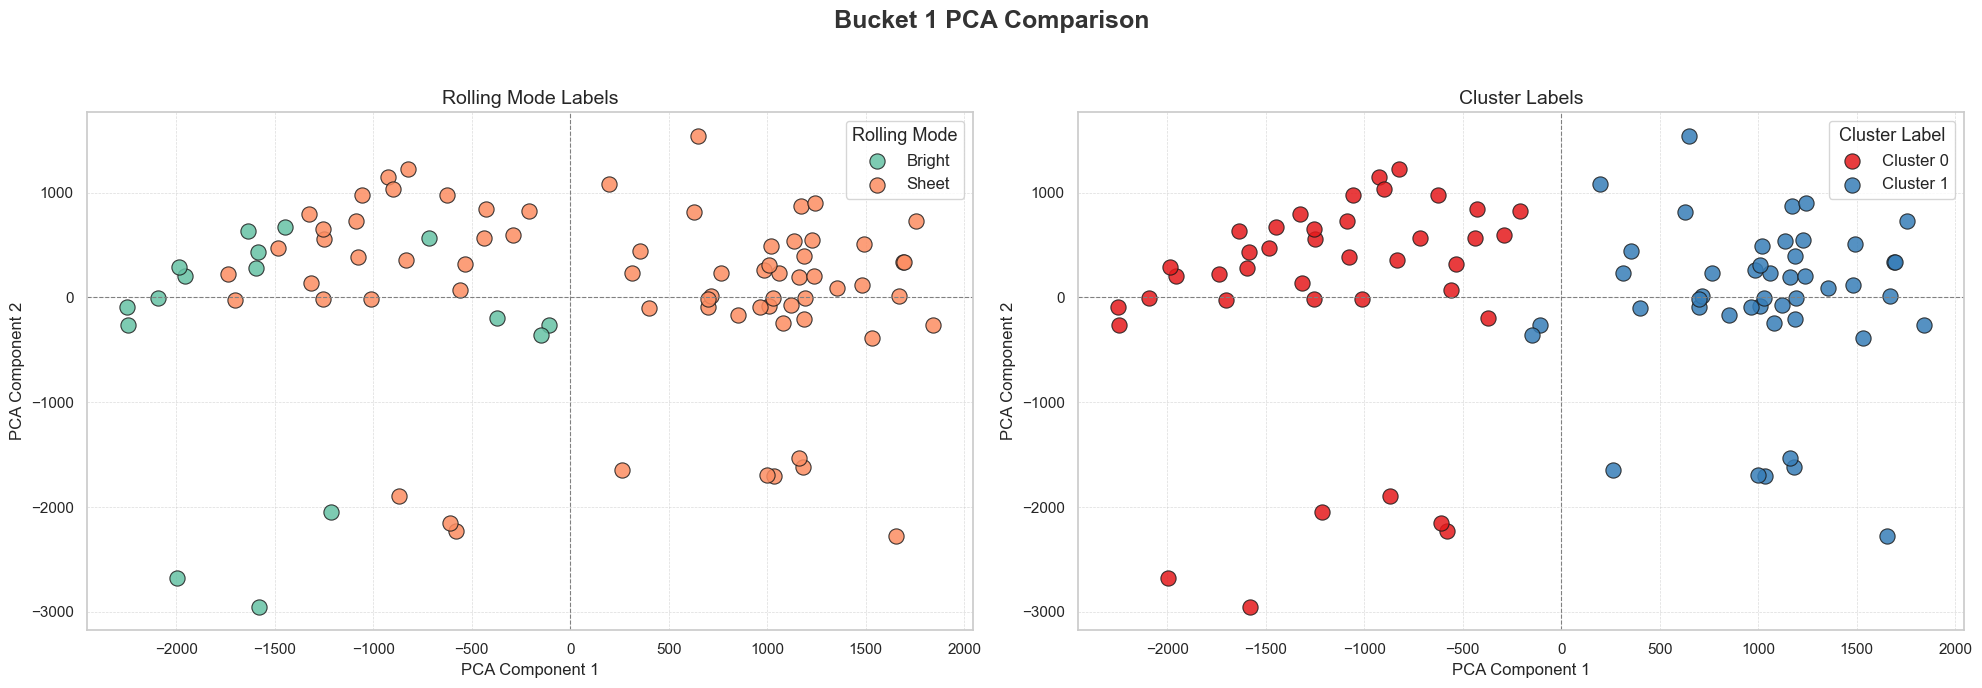

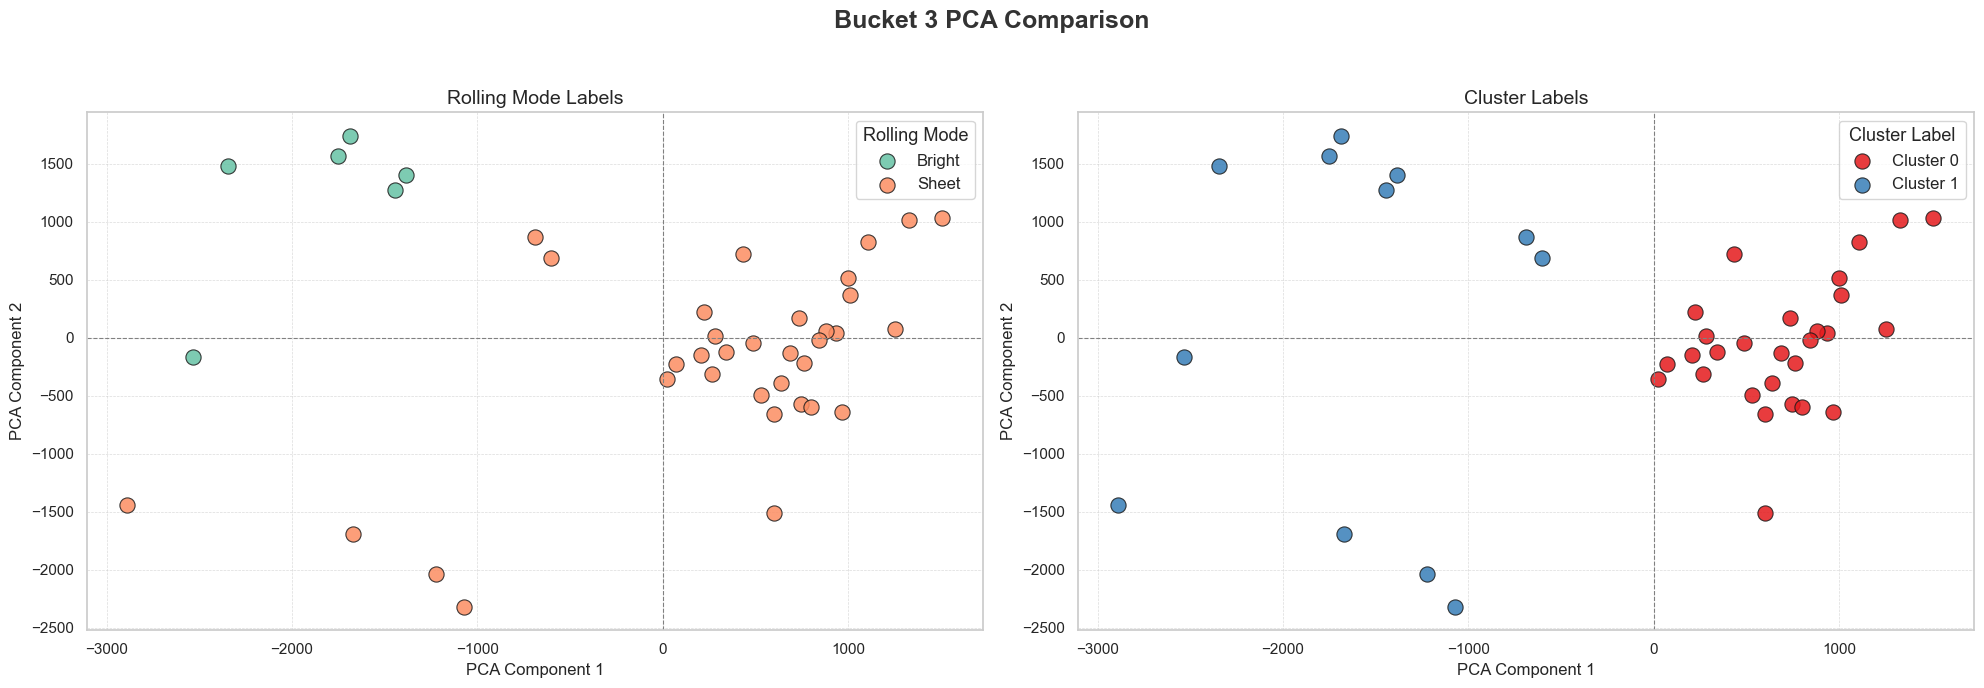

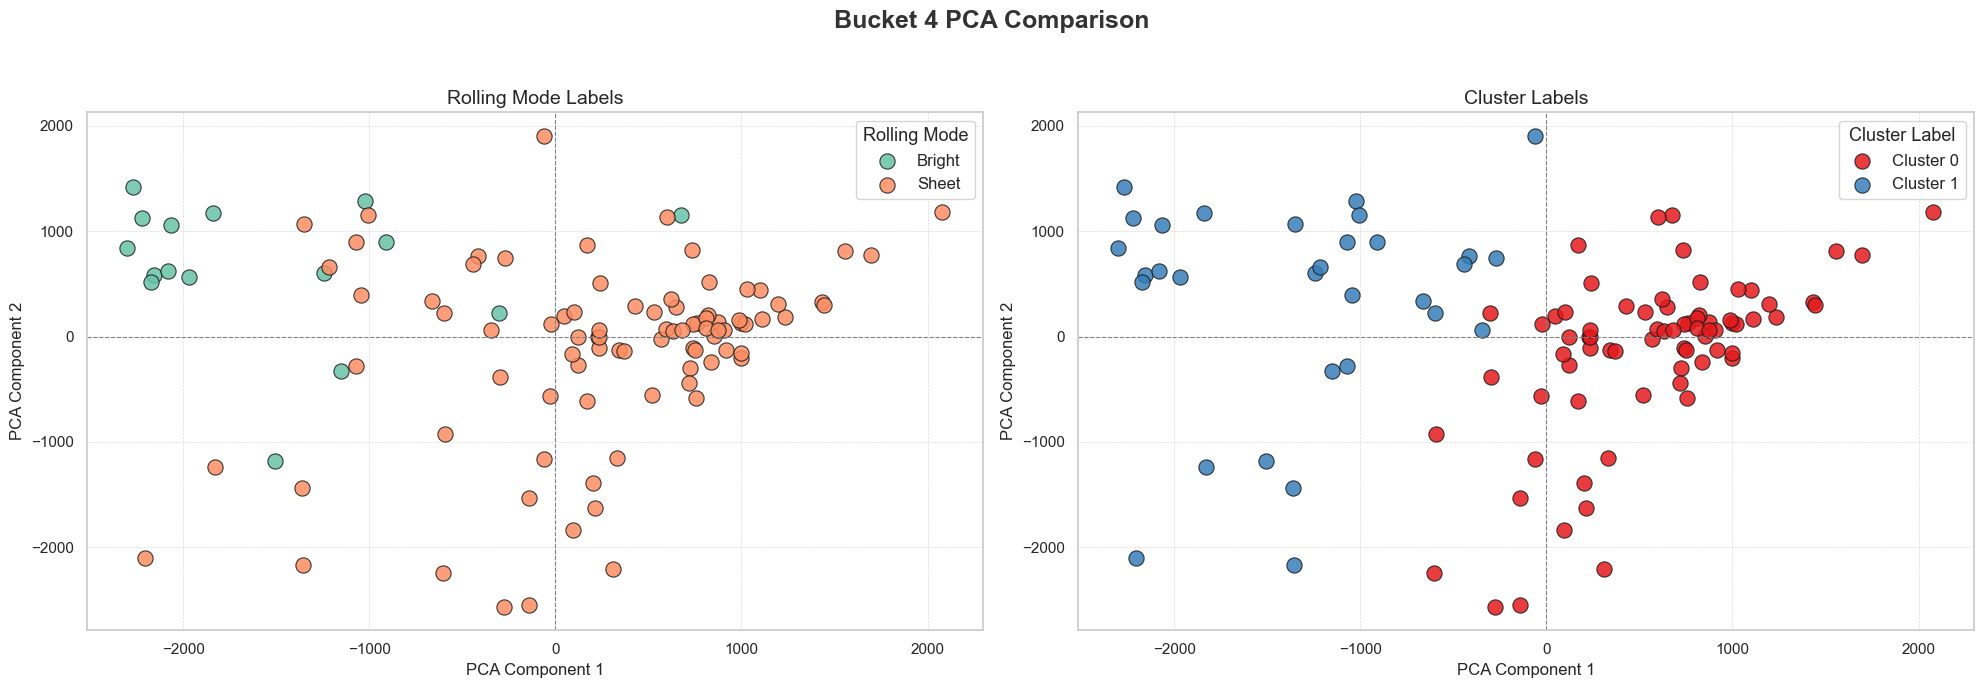

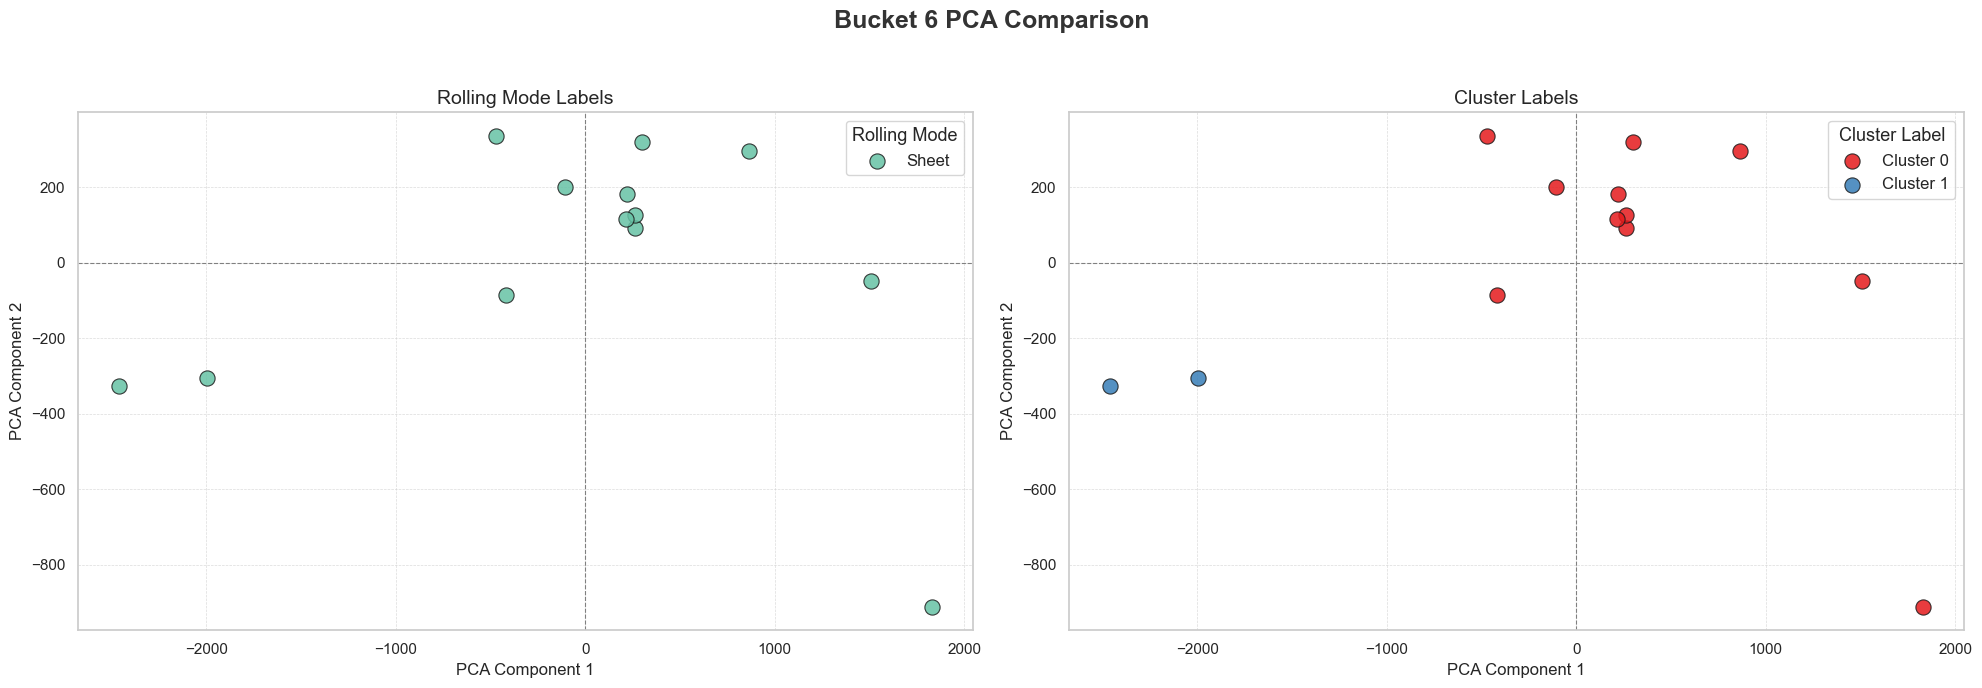

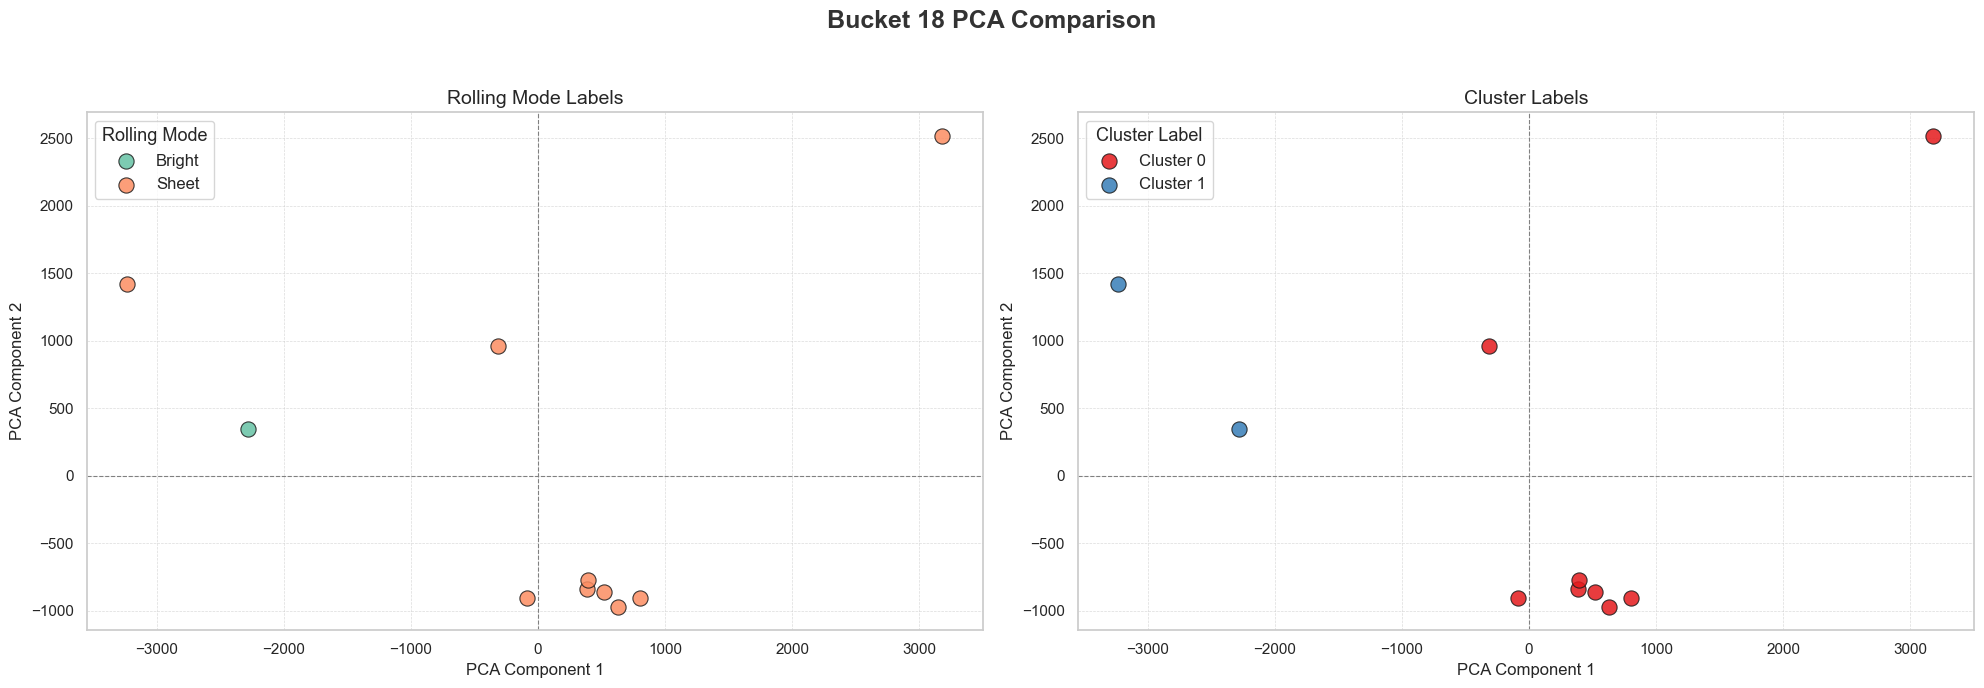

PCA comparison plots saved to 'bucketwise_pca_comparison_badcoils_anova bucketwise.pdf'


In [19]:
bucketwise_pca_compare_rollingmode_clusters_save_pdf(
    df=df_filtered, signal_cols=signal_names
)